Import dan Setup

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2

Load Dataset

In [9]:
graded_csv = r"E:\DragonEye\dataset\graded_features.csv"
quality_csv = r"E:\DragonEye\dataset\graded_texture_quality.csv"

df_grade = pd.read_csv(graded_csv)
df_quality = pd.read_csv(quality_csv)

df = pd.merge(df_grade, df_quality, on="filename", how="left")

print("Kolom setelah merge:", df.columns)
df.head()


Kolom setelah merge: Index(['filename', 'area_cm2_x', 'width_cm_x', 'height_cm_x', 'weight_est_g_x',
       'texture_score_x', 'hue_mean_x', 'grade_by_weight', 'area_norm',
       'weight_norm', 'texture_norm_x', 'fuzzy_score', 'grade_label',
       'label_asli', 'area_cm2_y', 'width_cm_y', 'height_cm_y',
       'weight_est_g_y', 'texture_score_y', 'hue_mean_y', 'hue_norm',
       'texture_norm_y', 'texture_grade_score', 'texture_grade_label'],
      dtype='object')


,filename,area_cm2_x,width_cm_x,height_cm_x,weight_est_g_x,texture_score_x,hue_mean_x,grade_by_weight,area_norm,weight_norm,...,area_cm2_y,width_cm_y,height_cm_y,weight_est_g_y,texture_score_y,hue_mean_y,hue_norm,texture_norm_y,texture_grade_score,texture_grade_label
0,A_001.jpg,134.9231,14.832,12.274,563.156,0.045618,0.502567,A,0.527005,0.508304,...,134.9231,14.832,12.274,563.156,0.045618,0.502567,0.646965,0.507935,87.068743,Good
1,A_002.jpg,138.0154,13.429,13.729,578.025,0.043557,0.499815,A,0.551259,0.532826,...,138.0154,13.429,13.729,578.025,0.043557,0.499815,0.625788,0.442123,86.815817,Good
2,A_003.jpg,129.0906,14.956,12.821,535.253,0.064716,0.523577,A,0.481257,0.462285,...,129.0906,14.956,12.821,535.253,0.064716,0.523577,0.808641,1.000000,86.078629,Good
3,A_004.jpg,138.7851,13.712,13.094,581.734,0.054638,0.487776,A,0.557296,0.538943,...,138.7851,13.712,13.094,581.734,0.054638,0.487776,0.533145,0.795965,85.828662,Good
4,A_005.jpg,139.7328,13.738,13.147,586.304,0.052429,0.489283,A,0.564729,0.546480,...,139.7328,13.738,13.147,586.304,0.052429,0.489283,0.544742,0.725426,84.957566,Good


Evaluasi Akurasi & Confusion Matrix

===== EVALUASI HASIL GRADING =====
Akurasi : 0.34772182254196643

Confusion Matrix:
 [[141   0   0]
 [139   0   4]
 [  4 125   4]]

Classification Report:
               precision    recall  f1-score   support

           A       0.50      1.00      0.66       141
           B       0.00      0.00      0.00       143
           C       0.50      0.03      0.06       133

    accuracy                           0.35       417
   macro avg       0.33      0.34      0.24       417
weighted avg       0.33      0.35      0.24       417



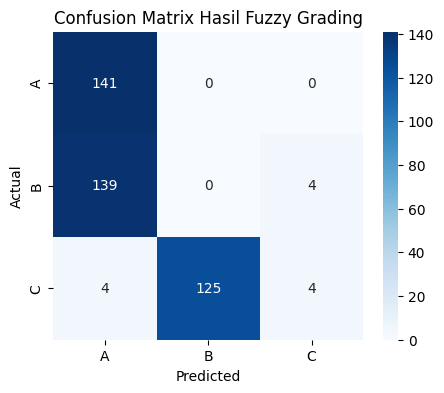

In [10]:
y_true = df['label_asli']
y_pred = df['grade_label']

print("===== EVALUASI HASIL GRADING =====")
print("Akurasi :", accuracy_score(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred, labels=['A', 'B', 'C'])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['A', 'B', 'C'], yticklabels=['A', 'B', 'C'])
plt.title("Confusion Matrix Hasil Fuzzy Grading")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Distribusi Grade

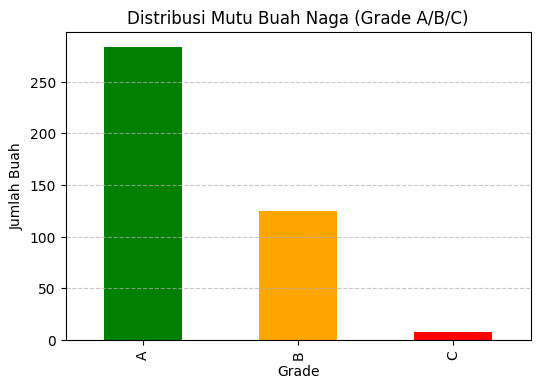

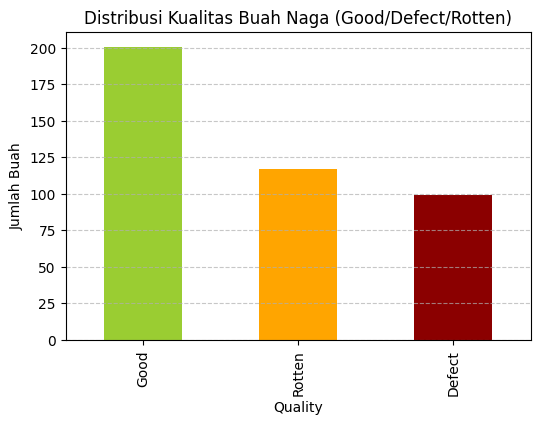

In [11]:
# Visualisasi distribusi grade berdasarkan grading (A/B/C)
plt.figure(figsize=(6, 4))
df['grade_label'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.title("Distribusi Mutu Buah Naga (Grade A/B/C)")
plt.xlabel("Grade")
plt.ylabel("Jumlah Buah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualisasi distribusi kualitas berdasarkan kualitas (Good/Defect/Rotten)
plt.figure(figsize=(6, 4))
df['texture_grade_label'].value_counts().plot(kind='bar', color=['yellowgreen', 'orange', 'darkred'])
plt.title("Distribusi Kualitas Buah Naga (Good/Defect/Rotten)")
plt.xlabel("Quality")
plt.ylabel("Jumlah Buah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Visualisasi Sebaran Fitur

In [12]:
# Periksa kolom yang ada dalam DataFrame
print(df.columns)

# Scatter plot untuk ukuran dan berat berdasarkan grade
if 'area_cm2' in df.columns and 'weight_est_g' in df.columns:
    sns.scatterplot(data=df, x='area_cm2', y='weight_est_g', hue='grade_label', palette='Set1', s=60)
    plt.title("Sebaran Ukuran vs Berat Berdasarkan Grade")
    plt.xlabel("Area (Ukuran, cm²)")
    plt.ylabel("Estimasi Berat (gram)")
    plt.legend(title="Grade")
    plt.show()
else:
    print("Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.")

# Scatter plot untuk ukuran dan berat berdasarkan kualitas (Good/Defect/Rotten)
if 'area_cm2' in df.columns and 'weight_est_g' in df.columns:
    sns.scatterplot(data=df, x='area_cm2', y='weight_est_g', hue='texture_grade_label', palette='Set2', s=60)
    plt.title("Sebaran Ukuran vs Berat Berdasarkan Kualitas")
    plt.xlabel("Area (Ukuran, cm²)")
    plt.ylabel("Estimasi Berat (gram)")
    plt.legend(title="Quality")
    plt.show()
else:
    print("Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.")

Index(['filename', 'area_cm2_x', 'width_cm_x', 'height_cm_x', 'weight_est_g_x',
       'texture_score_x', 'hue_mean_x', 'grade_by_weight', 'area_norm',
       'weight_norm', 'texture_norm_x', 'fuzzy_score', 'grade_label',
       'label_asli', 'area_cm2_y', 'width_cm_y', 'height_cm_y',
       'weight_est_g_y', 'texture_score_y', 'hue_mean_y', 'hue_norm',
       'texture_norm_y', 'texture_grade_score', 'texture_grade_label'],
      dtype='object')
Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.
Kolom 'area_cm2' atau 'weight_est_g' tidak ditemukan di DataFrame.


Tampilkan Beberapa Gambar Contoh

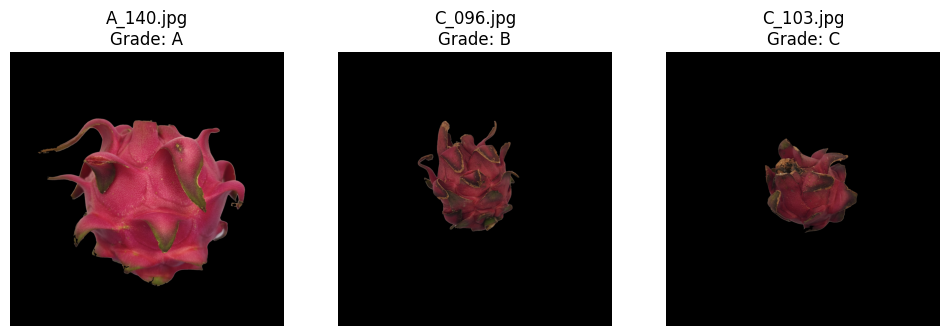

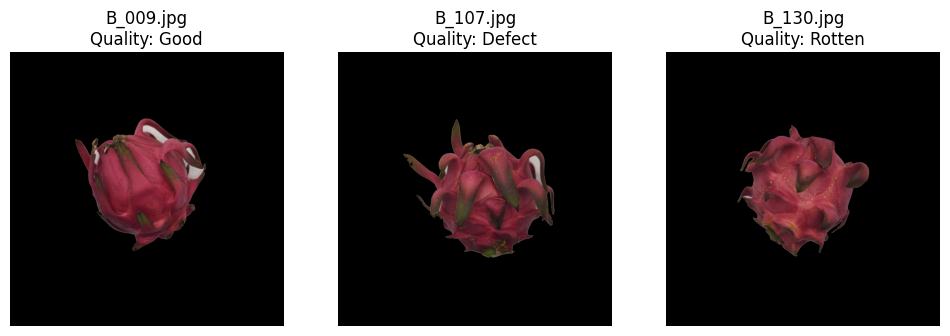

In [13]:
SEGMENTED_DIR = r"E:\DragonEye\dataset\segmented"

# Filter DataFrame untuk masing-masing grade dan ambil satu sampel untuk tiap grade
samples_A = df[df['grade_label'] == 'A'].sample(n=1)
samples_B = df[df['grade_label'] == 'B'].sample(n=1)
samples_C = df[df['grade_label'] == 'C'].sample(n=1)

# Gabungkan sampel dari ketiga grade
samples = pd.concat([samples_A, samples_B, samples_C])

# Plotting gambar berdasarkan grade
plt.figure(figsize=(12, 4))
for i, (_, row) in enumerate(samples.iterrows()):
    img_path = os.path.join(SEGMENTED_DIR, row['filename'])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah BGR ke RGB untuk tampilan yang benar
        plt.subplot(1, 3, i + 1)  # Menyusun 3 gambar dalam 1 baris
        plt.imshow(img)
        plt.title(f"{row['filename']}\nGrade: {row['grade_label']}")
        plt.axis('off')
plt.show()

# Visualisasi sampel berdasarkan kualitas (Good/Defect/Rotten)
samples_good = df[df['texture_grade_label'] == 'Good'].sample(n=1)
samples_defect = df[df['texture_grade_label'] == 'Defect'].sample(n=1)
samples_rotten = df[df['texture_grade_label'] == 'Rotten'].sample(n=1)

samples_quality = pd.concat([samples_good, samples_defect, samples_rotten])

# Plotting gambar berdasarkan kualitas
plt.figure(figsize=(12, 4))
for i, (_, row) in enumerate(samples_quality.iterrows()):
    img_path = os.path.join(SEGMENTED_DIR, row['filename'])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah BGR ke RGB untuk tampilan yang benar
        plt.subplot(1, 3, i + 1)  # Menyusun 3 gambar dalam 1 baris
        plt.imshow(img)
        plt.title(f"{row['filename']}\nQuality: {row['texture_grade_label']}")
        plt.axis('off')
plt.show()
